In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import densenet121
from PIL import Image

In [2]:
model = densenet121(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 64.6MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image


In [5]:
def extract_features(image_tensor):
    with torch.no_grad():
        features = model.features(image_tensor)
    return features

In [13]:
def high_frequency_component(features):
    features_np = features.squeeze().cpu().numpy()

    high_freq_maps = []
    for i in range(features_np.shape[0]):
        feature_map = features_np[i].astype(np.float64)
        high_freq = cv2.Laplacian(feature_map, cv2.CV_64F)
        high_freq_maps.append(high_freq)

    return torch.tensor(np.stack(high_freq_maps))

In [7]:
def noise_difference(image1_path, image2_path):
    img1 = load_and_preprocess_image(image1_path)
    img2 = load_and_preprocess_image(image2_path)

    features1 = extract_features(img1)
    features2 = extract_features(img2)

    high_freq1 = high_frequency_component(features1)
    high_freq2 = high_frequency_component(features2)

    noise_diff = torch.abs(high_freq1 - high_freq2)
    avg_noise_diff = torch.mean(noise_diff).item()

    return noise_diff, avg_noise_diff

Real vs Fake

In [10]:
# Paths to input images (one real, one fake)
image1_path = "/content/fake 1.png"
image2_path = "/content/real 4.jpg"


In [14]:
# Calculate noise difference
noise_diff, avg_noise_diff = noise_difference(image1_path, image2_path)

print(f"Average Noise Difference: {avg_noise_diff}")


Average Noise Difference: 1.4127286165303397


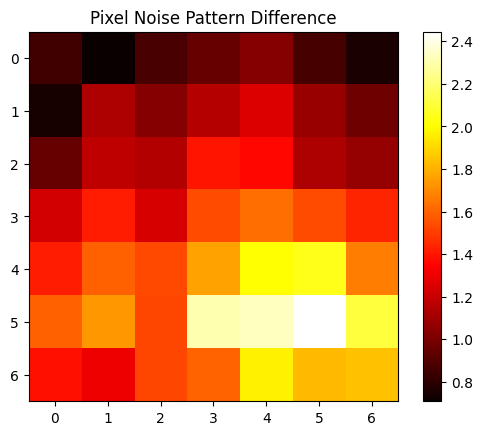

In [15]:
import matplotlib.pyplot as plt

plt.imshow(noise_diff.mean(dim=0), cmap='hot')
plt.colorbar()
plt.title("Pixel Noise Pattern Difference")
plt.show()

Real vs Real

In [16]:
image1_path = "/content/real 3.png"
image2_path = "/content/real 4.jpg"

In [17]:
noise_diff, avg_noise_diff = noise_difference(image1_path, image2_path)

print(f"Average Noise Difference: {avg_noise_diff}")

Average Noise Difference: 1.4971154344096516


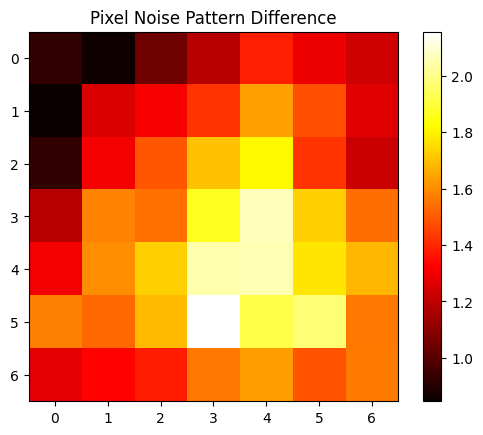

In [18]:
import matplotlib.pyplot as plt

plt.imshow(noise_diff.mean(dim=0), cmap='hot')
plt.colorbar()
plt.title("Pixel Noise Pattern Difference")
plt.show()

Fake vs Fake

In [21]:
image1_path = "/content/fake 1.png"
image2_path = "/content/fake 2.png"

In [22]:
noise_diff, avg_noise_diff = noise_difference(image1_path, image2_path)

print(f"Average Noise Difference: {avg_noise_diff}")

Average Noise Difference: 0.9909929631998584


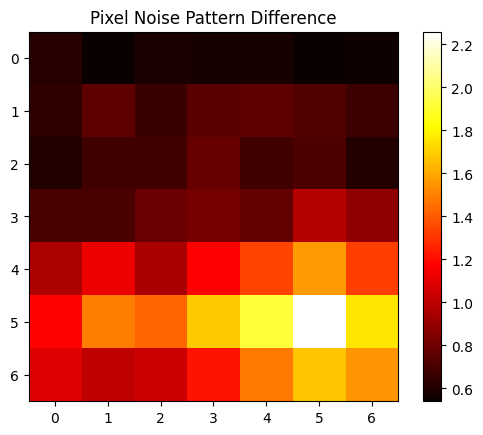

In [23]:
import matplotlib.pyplot as plt

plt.imshow(noise_diff.mean(dim=0), cmap='hot')
plt.colorbar()
plt.title("Pixel Noise Pattern Difference")
plt.show()



*   A higher value suggests that there is a significant difference in the noise patterns between the two images, which is often expected if one image is real (natural noise) and the other is AI-generated (synthetic noise).


*   A lower value (closer to 0) would imply that the noise patterns are very similar between the two images, which could happen if both images are either real or AI-generated by the same method.




Conclusion : we can take this one of the parameter for our project as it gave low frequency noise between FAKE images

Sources



*   Real images were taken from the camera.

*   Fake images were taken from a website named https://thispersondoesnotexist.com/





